# Logfile parsing
(back to overview [offline](../Main.ipynb),[online](https://nbviewer.jupyter.org/github/QCoDeS/Qcodes/tree/master/docs/examples/Main.ipynb))

[read on nbviewer](https://nbviewer.jupyter.org/github/QCoDeS/Qcodes/tree/master/docs/examples/logging/logfile_parsing.ipynb)

In [2]:
%matplotlib notebook
import dateutil
import os

import pandas as pd
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.logger.log_analysis import logfile_to_dataframe, time_difference, log_to_dataframe
from zipfile import ZipFile


In [3]:
# put the 30MB into a zip file
filepath = os.path.join(os.getcwd(), 'static', 'pythonlog.zip')
with ZipFile(filepath) as z:
    with z.open('pythonlog.log', 'r') as f:
        my_log = [line.decode() for line in f]

In [4]:
os.path.exists(filepath)

True

In [7]:
logdata = log_to_dataframe(my_log, separator=' - ', columns=['time', 'module', 'function', 'loglevel', 'message'])

`logdata` is now a nice and tidy `DataFrame`

In [8]:
logdata

,time,module,function,loglevel,message
0,"2018-05-10 16:01:50,497",qcodes.instrument_drivers.QDev.QDac_channels,write,DEBUG,Writing to instrument qdac: wav 2 0 0 0;set 2 ...
1,"2018-05-10 16:01:50,546",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: OUTP? 2\r\n
2,"2018-05-10 16:01:50,552",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 8.9832...
3,"2018-05-10 16:01:50,553",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: SLVL?\r\n
4,"2018-05-10 16:01:50,561",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 9.9999...
5,"2018-05-10 16:01:50,561",qcodes.instrument_drivers.QDev.QDac_channels,write,DEBUG,Writing to instrument qdac: wav 2 0 0 0;set 2 ...
6,"2018-05-10 16:01:50,610",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: OUTP? 2\r\n
7,"2018-05-10 16:01:50,617",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 6.3923...
8,"2018-05-10 16:01:50,618",qcodes.instrument.visa,ask_raw,DEBUG,Querying instrument SR860_120: SLVL?\r\n
9,"2018-05-10 16:01:50,626",qcodes.instrument.visa,ask_raw,DEBUG,Got response from instrument SR860_120: 9.9999...


In [9]:
data = logdata

### Get the query time for the SR860

We know that the log file documents an experiment quering an SR860 for R and amplitude over and over.

In [13]:
qstr_R = 'Querying instrument SR860_120: OUTP\? 2'  # remember to escape
queries_R = data[data.message.str.contains(qstr_R)]
responses_R = data.loc[queries_R.index + 1]

qstr_lvl = 'Querying instrument SR860_120: SLVL\?'  # remember to escape
queries_lvl = data[data.message.str.contains(qstr_lvl)][:-1]
responses_lvl = data.loc[queries_lvl.index + 1]

### Find the elapsed times

In [14]:
elapsed_times_R = time_difference(queries_R.time, responses_R.time)
elapsed_times_lvl =  time_difference(queries_lvl.time, responses_lvl.time)

## Visualise!

<IPython.core.display.Javascript object>


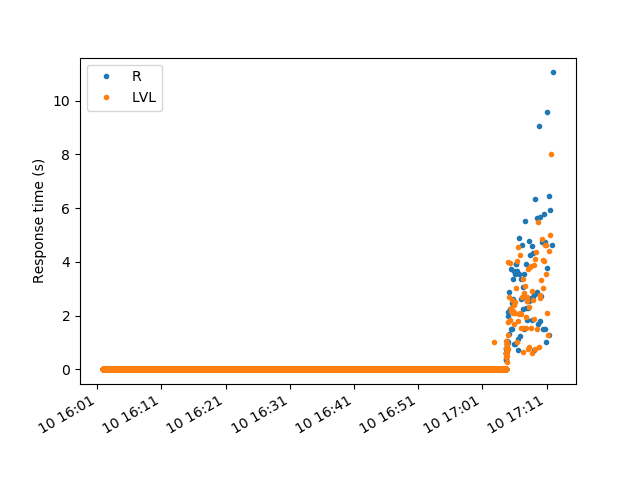

In [15]:


fig, ax = plt.subplots(1,1)
ax.plot(queries_R.time.str.replace(',', '.').astype("datetime64[ns]"), elapsed_times_R, '.', label='R')
ax.plot(queries_lvl.time.str.replace(',', '.').astype("datetime64[ns]"), elapsed_times_lvl, '.', label='LVL')
fig.autofmt_xdate()
ax.set_ylabel('Response time (s)')
plt.legend()